---
Layer Wise Propagation (LRP) introduction 
---


**Description:**  
A basic intro to the propagtion method
### Additional Comments
### Author: Viswambhar Yasa

### Date: 09-01-2024

**Contact Information:**  
Email: [yasa.viswambhar@gmail.com](mailto:yasa.viswambhar@gmail.com)

In [9]:
import os
import io
import sys
import torch
from PIL import Image
from pathlib import Path
import torch.nn.functional as F
import matplotlib.pyplot as plt
from crp.image import imgify,vis_opaque_img

In [2]:
notebook_directory = Path().resolve().parent
sys.path.insert(0,str(notebook_directory.parent))
from experiment.helper_functions import load_dict
from sentinelmodels.pretrained_models import buildmodel
from interpet.LRP import LRPModel

In [3]:

config={    
                "root_dir":r'D:/master-thesis/Dataset/anthroprotect',
                "datasplitfilename": r"infos.csv",
                "n_classes":2,
                "datasaved":True,
                "device":"cpu",
                "models":["alexnet","vgg16","resnet18"],
                "modelweightpaths":[r"D:/Thesis/ExplainingWilderness/experiments/figures/trained_models/pretrained/alexnet_best_model.pth",
                                    r"D:/Thesis/ExplainingWilderness/experiments/figures/trained_models/pretrained/vgg16_best_model.pth",
                                    r"D:/Thesis/ExplainingWilderness/experiments/figures/trained_models/pretrained/resnet18_best_model.pth",
                                    ],
                "cmap":"hot",
                "symmetric":False,
                "level":1
                }

modelindex=-1
datafilepath=r"D:/finaldraft/ExplainingWilderness/experiment/Notebooks/data/wilderness_data.pkl"

loaded_data = dictionary = load_dict(datafilepath)
# Accessing the loaded images and labels
images = loaded_data["images"][-1,:,:,:].unsqueeze(dim=0).to(config["device"])
#images = loaded_data["images"].to(config["device"])

labels = loaded_data["labels"]

In [4]:
modelindex=1
model=buildmodel(model_type=config["models"][modelindex],multiclass_channels=config["n_classes"],modelweightpath=config["modelweightpaths"][modelindex]).to(config["device"])

In [5]:
lrp_model=LRPModel(model)

In [6]:
del model

In [7]:
lrp_model

LRPModel(
  (model): VGG16(
    (features): Sequential(
      (0): Conv2DLRP(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2DLRP(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2dLRP(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2DLRP(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2DLRP(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2dLRP(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2DLRP(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2DLRP(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2DLRP(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): R

In [8]:
prediction=lrp_model(images)

In [10]:
probabilities = torch.nn.functional.softmax(prediction, dim=-1)
print(probabilities.shape)

torch.Size([1, 2])


In [11]:
for index,layer in enumerate(lrp_model.layer_inputs.items()):
    print(index,layer[0],layer[1].shape)

0 Conv2DLRP(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) torch.Size([1, 3, 256, 256])
1 Conv2DLRP(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) torch.Size([1, 64, 256, 256])
2 MaxPool2dLRP(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) torch.Size([1, 64, 256, 256])
3 Conv2DLRP(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) torch.Size([1, 64, 128, 128])
4 Conv2DLRP(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) torch.Size([1, 128, 128, 128])
5 MaxPool2dLRP(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) torch.Size([1, 128, 128, 128])
6 Conv2DLRP(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) torch.Size([1, 128, 64, 64])
7 Conv2DLRP(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) torch.Size([1, 256, 64, 64])
8 Conv2DLRP(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) torch.Size([1, 256, 64, 64])
9 MaxPool2dLRP(kernel_size=2, stride=2, padding=0, dilation=1, ceil

In [12]:
explaination=lrp_model.interpet(images)

In [31]:
vis_opaque_img(images,explaination.sum(dim=1))

[<PIL.Image.Image image mode=RGB size=256x256>]

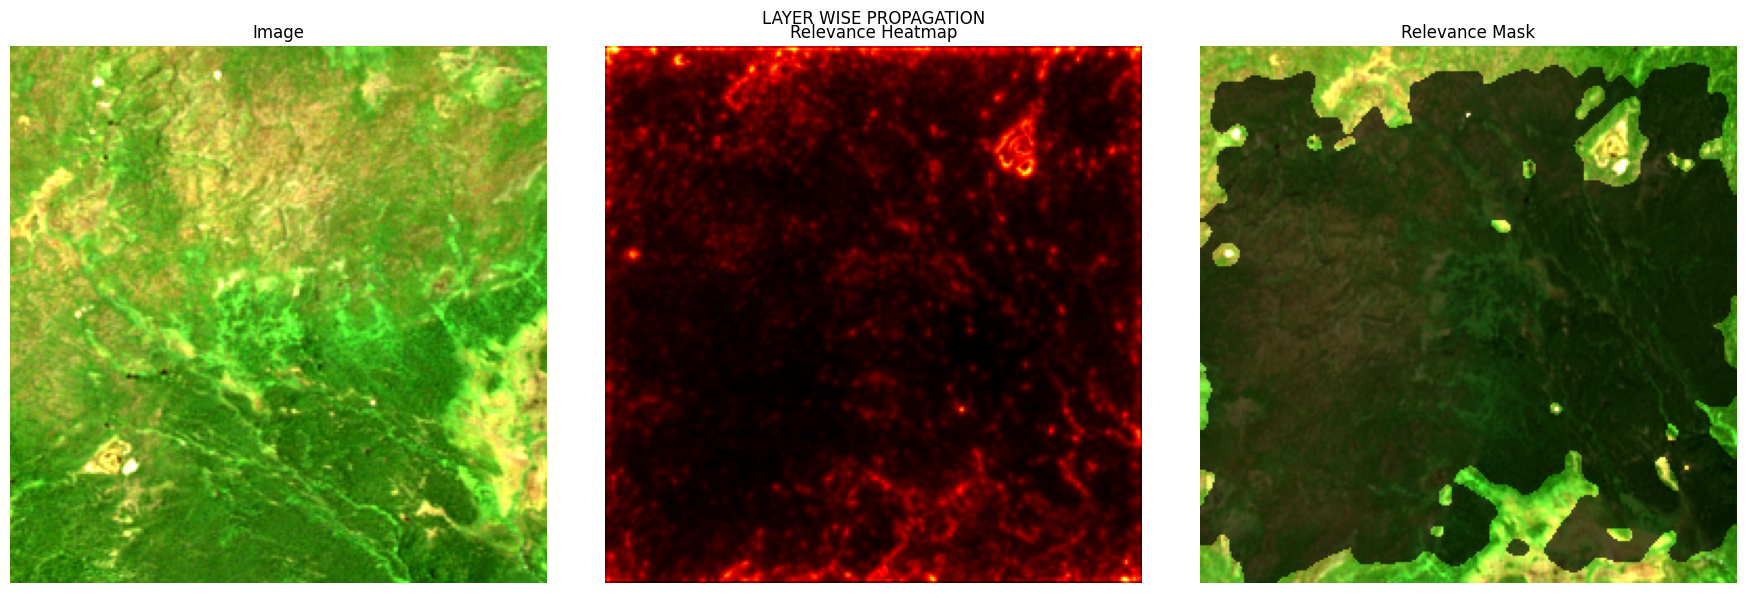

In [41]:
fig,ax=plt.subplots(1,3,figsize=(18,6))
ax[0].imshow(images.squeeze().detach().cpu().numpy().T)
ax[0].set_title("Image")
ax[0].axis("off")
ax[1].imshow(imgify(explaination.sum(dim=1).detach().cpu().numpy(),cmap="hot",symmetric=False,level=1))
ax[1].set_title("Relevance Heatmap")
ax[1].axis("off")
ax[2].imshow(vis_opaque_img(images,explaination.sum(dim=1))[0])
ax[2].set_title("Relevance Mask")
ax[2].axis("off")
plt.suptitle("LAYER WISE PROPAGATION")

plt.tight_layout()
saved_path="D:/finaldraft/ExplainingWilderness/experiment/Notebooks/temp/heatmaps"
plt.savefig(os.path.join(saved_path,"./"+config["models"][modelindex]+"_"+"lrp_heatmap.png"),dpi=600)
plt.show()